# Predict ETH price direction - Random Forest Classifier

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests
import datetime 

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_6.csv', parse_dates=True)

In [3]:
# Read in combined ETH Google trends data
eth_google_trends = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_google_trends/eth_trends_combined.csv', parse_dates=True)
eth_google_trends.reset_index(inplace=True)
eth_google_trends.rename(columns={'date':'time', 'ethereum':'ETH_Trends'},inplace=True)
eth_google_trends = eth_google_trends.drop(columns='index')
eth_google_trends['time'] = pd.to_datetime(eth_google_trends['time']).dt.date
eth_google_trends = eth_google_trends.set_index('time')
eth_google_trends.tail()

,ETH_Trends
time,
2021-07-30,22
2021-07-31,25
2021-08-01,28
2021-08-02,26
2021-08-03,27


In [4]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')
combined_df.tail()

,time,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
211,2021-07-31 00:00:00+00:00,eth,617087,1.733664,2.974903e+11,529.372834,37.374311,2544.375376,1.169207e+08,1212322,7.959753e+09,22.283453
212,2021-08-01 00:00:00+00:00,eth,611381,1.739536,2.997877e+11,537.360990,54.531904,2563.737531,1.169339e+08,1190618,5.497474e+09,22.271858
213,2021-08-02 00:00:00+00:00,eth,648782,1.763162,3.062894e+11,548.166186,48.900070,2619.040999,1.169472e+08,1269470,6.263579e+09,22.258925
214,2021-08-03 00:00:00+00:00,eth,599206,1.705551,2.939115e+11,557.910614,40.842571,2512.915292,1.169604e+08,1219663,7.196205e+09,22.253252
215,2021-08-04 00:00:00+00:00,eth,605815,1.794226,3.190962e+11,562.148424,37.550755,2727.934254,1.169736e+08,1223841,8.497730e+09,22.250033


In [5]:
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [6]:
# Remove timestamp in time column
combined_df['time'] = pd.to_datetime(combined_df['time']).dt.date
combined_df = combined_df.set_index('time')
combined.to_csv('resources/eth_annual_metrics/combined.csv')

In [7]:
# Concat metrics and google trends data
combined_df = pd.concat([combined_df,eth_google_trends],axis=1).dropna()
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index':'time'})
combined_df = combined_df.set_index('time')
combined_df.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends
time,,,,,,,,,,,,
2016-01-01,eth,2433,2.166056,7.010116e+07,0.483217,264.814266,0.920370,7.616628e+07,8233,264718.210777,1.362126,8.0
2016-01-02,eth,2486,2.226491,7.238322e+07,0.480767,370.221897,0.949990,7.619366e+07,9164,195513.065884,1.365054,4.0
2016-01-03,eth,2528,2.238090,7.294862e+07,0.494175,234.211669,0.957063,7.622134e+07,9258,311464.489292,1.369430,4.0
2016-01-04,eth,2623,2.222385,7.243632e+07,0.491670,626.141010,0.950000,7.624876e+07,9474,115686.914897,1.370961,5.0
2016-01-05,eth,2620,2.207573,7.189832e+07,0.492788,111.469298,0.942600,7.627660e+07,16430,645005.606026,1.384049,8.0


In [8]:
# Concat metrics and momentum (RSI) data
rsi_eth = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/rsi_eth.csv', parse_dates=True, index_col='time')
rsi_eth.head()

,RSI_14
time,
2016-01-15,86.294443
2016-01-16,71.492294
2016-01-17,76.851959
2016-01-18,82.425741
2016-01-19,69.323486


In [9]:
# Create model features dataframe
features_eth = pd.concat([combined_df,rsi_eth],axis=1).dropna()
features_eth.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends,RSI_14
time,,,,,,,,,,,,,
2016-01-15,eth,3217.0,2.819911,9.881420e+07,0.529689,99.833385,1.290891,7.654728e+07,9875.0,9.897912e+05,1.440829,17.0,86.294443
2016-01-16,eth,2774.0,2.663106,9.279137e+07,0.537548,173.210602,1.211790,7.657381e+07,10664.0,5.357142e+05,1.447819,9.0,71.492294
2016-01-17,eth,2667.0,2.641324,1.004183e+08,0.528554,246.199968,1.310937,7.660041e+07,9747.0,4.078729e+05,1.452236,5.0,76.851959
2016-01-18,eth,3137.0,2.799078,1.123539e+08,0.555149,39.590724,1.466244,7.662703e+07,12916.0,2.837885e+06,1.484658,11.0,82.425741
2016-01-19,eth,2933.0,2.611014,1.037152e+08,0.548841,85.541365,1.353047,7.665312e+07,13420.0,1.212457e+06,1.500391,20.0,69.323486


In [10]:
features_eth.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/features_eth.csv')

<AxesSubplot:title={'center':'EMA ETH'}, xlabel='time', ylabel='ETH Price ($)'>

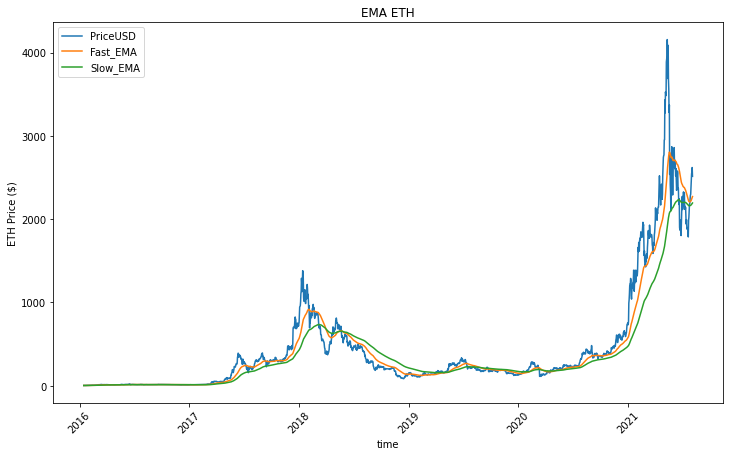

In [11]:
# Set short and long windows for EMA (Exponential Moving Average) to create trading signals feature
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
features_eth['Fast_EMA'] = features_eth['PriceUSD'].ewm(halflife=short_window).mean()
features_eth['Slow_EMA'] = features_eth['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
features_eth[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA ETH', ylabel='ETH Price ($)', rot=45) 

In [12]:
# Construct a crossover trading signal
features_eth['Crossover_Long'] = np.where(features_eth['Fast_EMA'] > features_eth['Slow_EMA'], 1.0, 0.0)
features_eth['Crossover_Short'] = np.where(features_eth['Fast_EMA'] < features_eth['Slow_EMA'],-1.0, 0.0)
features_eth['Crossover_Signal'] = features_eth['Crossover_Long'] + features_eth['Crossover_Short']

In [13]:
# Calculate daily return
features_eth['Daily_Return'] = features_eth['PriceUSD'].pct_change()

In [14]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
features_eth['Positive_Return'] = np.where(features_eth['Daily_Return'] > 0, 1.0, 0.0)

features_eth = features_eth.dropna()

# Convert date to str to set test and train windows 
features_eth.index = pd.to_datetime(features_eth.index, format = '%Y/%m/%d')
features_eth.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends,RSI_14,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
time,,,,,,,,,,,,,,,,,,,,
2016-01-16,eth,2774.0,2.663106,9.279137e+07,0.537548,173.210602,1.211790,7.657381e+07,10664.0,5.357142e+05,1.447819,9.0,71.492294,1.250655,1.251066,0.0,-1.0,-1.0,-0.061276,0.0
2016-01-17,eth,2667.0,2.641324,1.004183e+08,0.528554,246.199968,1.310937,7.660041e+07,9747.0,4.078729e+05,1.452236,5.0,76.851959,1.271449,1.271301,1.0,0.0,1.0,0.081819,1.0
2016-01-18,eth,3137.0,2.799078,1.123539e+08,0.555149,39.590724,1.466244,7.662703e+07,12916.0,2.837885e+06,1.484658,11.0,82.425741,1.322708,1.321054,1.0,0.0,1.0,0.118470,1.0
2016-01-19,eth,2933.0,2.611014,1.037152e+08,0.548841,85.541365,1.353047,7.665312e+07,13420.0,1.212457e+06,1.500391,20.0,69.323486,1.329204,1.327632,1.0,0.0,1.0,-0.077202,0.0
2016-01-20,eth,3455.0,2.767653,1.116932e+08,0.549098,154.140822,1.456622,7.667966e+07,10610.0,7.246182e+05,1.507725,13.0,73.477763,1.352321,1.349882,1.0,0.0,1.0,0.076549,1.0


In [15]:
# Select model features and timeframe for train data
X = features_eth[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal','ETH_Trends','RSI_14']]
X_train = X.loc['2016':'2020']

In [16]:
# Select prediction variable and timeframe for train data
y = features_eth['Positive_Return']
y_train = y['2016':'2020']

In [17]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [18]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [19]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [20]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [21]:
# Create the decision tree classifier instance and calculate the optimal tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))

Best: 0.605941 using {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 500}


In [22]:
# Define the model using optimized settings (also use if you want to run without optimizer above)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(n_jobs=-1)
model = RandomForestClassifier(criterion='gini', max_depth=5,n_estimators=500, n_jobs=-1)

In [23]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [24]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [25]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [26]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,49,44
Actual 1,38,84


Accuracy Score : 0.6186046511627907
Classification Report
              precision    recall  f1-score   support

         0.0       0.56      0.53      0.54        93
         1.0       0.66      0.69      0.67       122

    accuracy                           0.62       215
   macro avg       0.61      0.61      0.61       215
weighted avg       0.62      0.62      0.62       215



In [27]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-20:]

,Positive_Return,Predicted Value
time,,
2021-07-15,0.0,0.0
2021-07-16,0.0,0.0
2021-07-17,1.0,0.0
2021-07-18,0.0,0.0
2021-07-19,0.0,0.0
2021-07-20,0.0,0.0
2021-07-21,1.0,0.0
2021-07-22,1.0,0.0
2021-07-23,1.0,0.0


In [28]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.36814103102442763, 'RSI_14'),
 (0.10166772467562779, 'CapMVRVCur'),
 (0.07580672140815149, 'NVTAdj'),
 (0.07088887365190284, 'VelCur1yr'),
 (0.070854586218572, 'TxCnt'),
 (0.06927358020256164, 'CapMrktCurUSD'),
 (0.06526076605428639, 'TxTfrValAdjUSD'),
 (0.06303210214471179, 'AdrActCnt'),
 (0.061316766473782994, 'HashRate'),
 (0.0494618523856349, 'ETH_Trends'),
 (0.0042959957603405955, 'Crossover_Signal')]

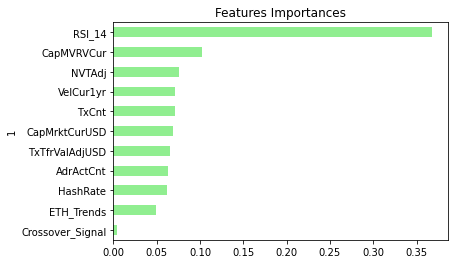

In [29]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)

In [ ]:
# RSI is the most dominant feature which shows that ETH price is primarily determined by momentum.